# California Recovered Ghost Guns

## Reformating the Data Frame

Data Retrieved from [Gun Violence Data Hub](https://datahub.thetrace.org/dataset/california-ghost-guns-stolen-guns-and-more/#details)

Specifically working with their `ca_ghost_guns_by_county_monthly.csv` data set, because it is their more updated data set.

In [2]:
import pandas as pd

# IMPORT df
og = pd.read_csv("ca_ghost_guns_by_county_monthly.csv")


# CHANGE TYPE from date to date-time
# so Pandas can read the data in the year_month column
og["year_month"] = pd.to_datetime(og["year_month"])


### Monthly and Yearly total of Gun-Related Crimes and Recovered Ghost Guns in California

In [3]:
# CA - MONTHLY Total Crimes and Ghost Guns - ca_monthly (2010-2025)
ca_monthly = og.groupby(["year", "year_month"], as_index=False).agg({"total_crime_guns":"sum", "ghost_guns":"sum"})


# CA - YEARLY Total Crimes and Ghost Guns - ca_yearly (2010-2024)
ca_yearly = og.groupby("year", as_index=False).agg({"total_crime_guns":"sum", "ghost_guns":"sum"})
ca_yearly = ca_yearly[(ca_yearly["year"] < 2025)]


### Yearly, Ghost Guns per 100k on a County Level

Adding a Ghost Guns Recovered per 100,000 Population column to the og data frame.

Rateper100,000=(NumberofCases/PopulationSize)∗100,000

In [4]:
# GROUPBY County, Year and Population, TOT of Gun Related Crims and Ghost Guns Recovered
# as_index=False saved my life!
county = og.groupby(["county", "year", "population"], as_index=False).agg({"total_crime_guns":"sum", "ghost_guns":"sum"})
county = county[(county["year"] < 2025)]

# MAKE NEW COLUMN - Ghost Guns per 100k
county["ghost_guns_per_100k"] = (county["ghost_guns"] / county["population"]) * 100000
county["ghost_guns_per_100k"] = county["ghost_guns_per_100k"].round(2)

### Ratio of Ghost Guns to Gun-Related Crimes, Yearly

In [ ]:
# NEW COLUMN - ghost guns to crime ratio (2010-2024)
ca_ratio = ca_yearly

ca_ratio["gg_crime_ratio"] = (ca_ratio["ghost_guns"] / ca_ratio["total_crime_guns"])
ca_ratio["gg_crime_ratio"] = ca_ratio["gg_crime_ratio"].round(2)

### Export all Data Frames

In [ ]:
# EXPORT
# except og
ca_monthly.to_csv("ca_monthly.csv", index=False)
ca_yearly.to_csv("ca_yearly.csv", index=False)
county.to_csv("county.csv", index=False)

## Graph - Total Gun-Related Crimes and Ghost Guns Recovered in CA, monthly and yearly

In [7]:
from matplotlib import pyplot as plt
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


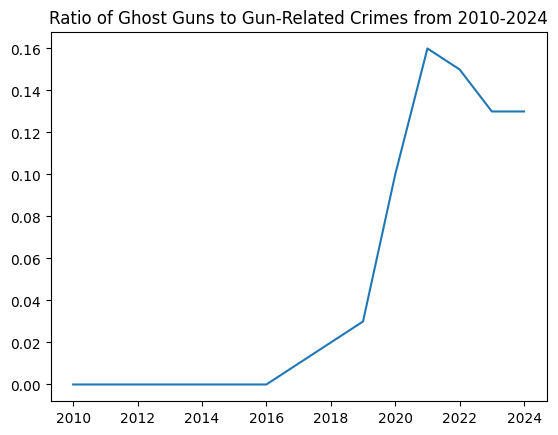

In [ ]:
# YEARLY - 2010 to 2024
# FIG6 (fig6)

## GRAPH
fig6 = plt.plot(ca_ratio["year"], ca_ratio["gg_crime_ratio"], label="Ratio")

fig6 = plt.title("Ratio of Ghost Guns to Gun-Related Crimes from 2010-2024")

## Stacked Line Graphs - Total Gun-Related Crimes and Ghost Guns Recovered in CA monthly and yearly

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

### Monthly 2010-2025

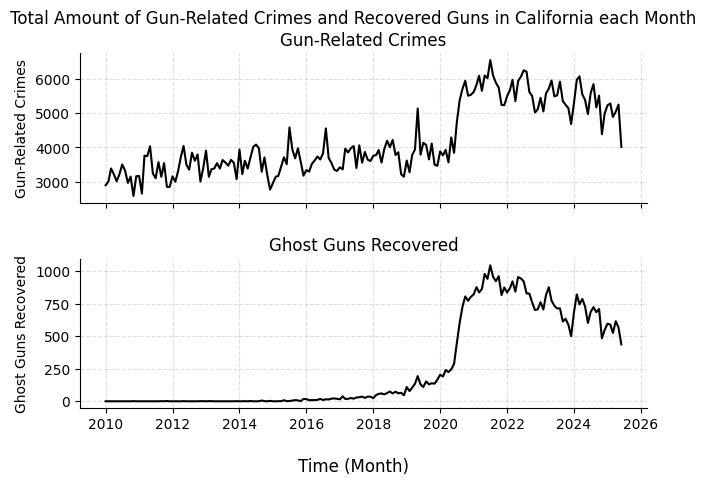

In [ ]:
# MONTHLY - 2010 to 20245


## STACKED graphs - subplots()
fig1, (crime, gg) = plt.subplots(nrows=2, sharex=True)
fig1.suptitle("Total Amount of Gun-Related Crimes and Recovered Guns in California each Month")
fig1.supxlabel("Time (Month)")

## SPACE between subplots
fig1.tight_layout(h_pad=3)


# GUN-RELATED Crimes
crime.plot(ca_monthly["year_month"], ca_monthly["total_crime_guns"], color="k")
## LABELS
crime.set_ylabel("Gun-Related Crimes")
crime.set_title("Gun-Related Crimes")
## AESTHETICS
crime.grid(color="0.5", alpha=0.25, linestyle="--")
crime.spines.top.set_visible(False)
crime.spines.right.set_visible(False)



# GHOST GUNS Recovered
gg.plot(ca_monthly["year_month"], ca_monthly["ghost_guns"], color="k")
##LABELS
gg.set_ylabel("Ghost Guns Recovered")
gg.set_title("Ghost Guns Recovered")
##AESTHETICS - gridlines, axis spines
gg.grid(color="0.5", alpha=0.25, linestyle="--")
gg.spines.top.set_visible(False)
gg.spines.right.set_visible(False)


### Yearly - 2010 to 2024

In [ ]:
# YEARLY - 2010 to 2024
# FIGURE 2 (fig2)


## STACKED graphs - subplots()
fig2, (crime, gg) = plt.subplots(nrows=2, sharex=True)
fig2.suptitle("Total Amount of Gun-Related Crimes and Recovered Guns in California each Year")
fig2.supxlabel("Time (Year)")

### SPACE between subplots
fig2.tight_layout(h_pad=3)


## GUN-RELATED Crimes
crime.plot(ca_yearly["year"], ca_yearly["total_crime_guns"], color="r")
### LABELS
crime.set_ylabel("Gun-Related Crimes")
crime.set_title("Gun-Related Crimes")
### AESTHETICS
crime.grid(color="0.5", alpha=0.25, linestyle="--")
crime.spines.top.set_visible(False)
crime.spines.right.set_visible(False)



## GHOST GUNS Recovered
gg.plot(ca_yearly["year"], ca_yearly["ghost_guns"], color="k")
### LABELS
gg.set_ylabel("Ghost Guns Recovered")
gg.set_title("Ghost Guns Recovered")
### AESTHETICS - gridlines, axis spines
gg.grid(color="0.5", alpha=0.25, linestyle="--")
gg.spines.top.set_visible(False)
gg.spines.right.set_visible(False)


### Monthly - 2016 to 2025

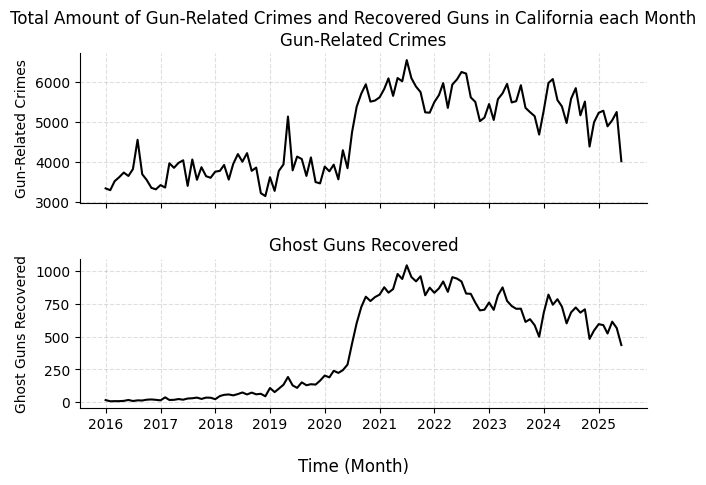

In [ ]:
# MONTHLY - 2016 to 2025
# FIGURE 3 (fig3)

# FILTER 2016 to 2025
ca_monthlyV2 = ca_monthly[(ca_monthly["year"] >= 2016)]


# STACKED graphs - subplots()
fig3, (crime, gg) = plt.subplots(nrows=2, sharex=True)
fig3.suptitle("Total Amount of Gun-Related Crimes and Recovered Guns in California each Month")
fig3.supxlabel("Time (Month)")

## SPACE between subplots
fig3.tight_layout(h_pad=3)


# GUN-RELATED Crimes
crime.plot(ca_monthlyV2["year_month"], ca_monthlyV2["total_crime_guns"], color="k")
## LABELS
crime.set_ylabel("Gun-Related Crimes")
crime.set_title("Gun-Related Crimes")
## AESTHETICS
crime.grid(color="0.5", alpha=0.25, linestyle="--")
crime.spines.top.set_visible(False)
crime.spines.right.set_visible(False)



# GHOST GUNS Recovered
gg.plot(ca_monthlyV2["year_month"], ca_monthlyV2["ghost_guns"], color="k")
## LABELS
gg.set_ylabel("Ghost Guns Recovered")
gg.set_title("Ghost Guns Recovered")
## AESTHETICS - gridlines, axis spines
gg.grid(color="0.5", alpha=0.25, linestyle="--")
gg.spines.top.set_visible(False)
gg.spines.right.set_visible(False)

### Yearly 2016-2024

NEXT GOAL: Add an equation line thing from 2021 to 2024, to see the slope

In [ ]:
# YEARLY - 2016 to 2024
# FIGURE 4 (fig4)

## FILTER 2018 to 2024
ca_yearlyV2 = ca_yearly[(ca_yearly["year"] >= 2016)]

# STACKED graphs - subplots()
fig4, (crime, gg) = plt.subplots(nrows=2, sharex=True)
fig4.suptitle("Total Amount of Gun-Related Crimes and Recovered Guns in California each Year")
fig4.supxlabel("Time (Year)")

## SPACE between subplots
fig4.tight_layout(h_pad=3)


# GUN-RELATED Crimes
crime.plot(ca_yearlyV2["year"], ca_yearlyV2["total_crime_guns"], color="r")
## LABELS
crime.set_ylabel("Gun-Related Crimes")
crime.set_title("Gun-Related Crimes")
## AESTHETICS
crime.grid(color="0.5", alpha=0.25, linestyle="--")
crime.spines.top.set_visible(False)
crime.spines.right.set_visible(False)



# GHOST GUNS Recovered
gg.plot(ca_yearlyV2["year"], ca_yearlyV2["ghost_guns"], color="k")
## LABELS
gg.set_ylabel("Ghost Guns Recovered")
gg.set_title("Ghost Guns Recovered")
## AESTHETICS - gridlines, axis spines
gg.grid(color="0.5", alpha=0.25, linestyle="--")
gg.spines.top.set_visible(False)
gg.spines.right.set_visible(False)


## Choropleth Map - County Level, yearly

The geoJSON file was taken from [here](https://lab.data.ca.gov/dataset/california-counties1).


In [10]:
import pandas as pd
import plotly.express as px
import geopandas as gpd

# READ geoJSON file with geopandas
map = gpd.read_file("California_Counties.geojson")

### Merging the geoJSON with my data frame

In [11]:
# FIX the "NAME" column of map
# REMOVE "county" from the ends of county names
map["NAME"] = map["NAME"].str.replace(" County","")

# MERGE county with map
final_county = map.merge(county, left_on="NAME", right_on="county", how="left")

In [12]:
# CONVERT geopandas read file to GeoJSON for plotly
import json
map_json = json.loads(map.to_json())

In [ ]:
# PLOT choropleth

# NEXT STEPS: Add population to the hover data

fig5 = px.choropleth(
    final_county,
    geojson=map_json,
    locations="NAME", # not indexed
    featureidkey="properties.NAME",
    color="ghost_guns_per_100k",
    animation_frame="year",
    animation_group="county",
    range_color=[0, 80],
    color_continuous_scale="ylorrd",
    projection="mercator",
    fitbounds="locations",
    basemap_visible=False,
    labels={
        "year":"Year",
        "NAME":"County",
        "ghost_guns_per_100k":"Ghost Guns per 100k"
        }
    )

# AESTHETICS
fig5.update_layout(
    title_text="Ghost Guns per 100,000 People",
    title_subtitle_text="Recovered Ghost Guns per 100,000 People in California Counties Each Year"
)

fig5.show()